# Two-Stage LGBM Mortality Prediction (Offset Poisson)

This notebook implements the **actuarially correct** offset Poisson approach:

```
log(E[Death_Count]) = log(Exposure) + f(X)
                      ↑ offset       ↑ model learns this
```

## Key Change from Previous Version
- **Before**: `sample_weight = Policies_Exposed` (incorrect)
- **After**: `init_score = log(Policies_Exposed)` (correct offset)

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Setup complete!')

Setup complete!


## 1. Load Cleaned Data

In [2]:
# Load cleaned data
DATA_PATH = '../data/ilec_cleaned.parquet'
df = pd.read_parquet(DATA_PATH)

# Sample 10% for memory efficiency
df = df.sample(frac=0.1, random_state=42)

print(f'Data shape: {df.shape}')
print(f'Memory: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB')
df.head()

Data shape: (4550104, 14)
Memory: 2.31 GB


,Observation_Year,Sex,Smoker_Status,Insurance_Plan,Issue_Age,Duration,Face_Amount_Band,Attained_Age,SOA_Antp_Lvl_TP,SOA_Guar_Lvl_TP,SOA_Post_Lvl_Ind,Preferred_Class,Policies_Exposed,Death_Count
26205050,2017,M,U,Term,3,22,"03: 25,000 - 49,999",24,Not Level Term,Not Level Term,NLT,NA,0.378082,0
19244556,2016,F,NS,Term,52,13,"07: 500,000 - 999,999",64,30 yr anticipated,30 yr guaranteed,WLT,3.0,0.350685,0
8169766,2013,M,NS,Term,70,17,"02: 10,000 - 24,999",86,Unknown,Unknown,ULT,2.0,0.863013,0
20571633,2016,M,NS,VL,14,28,"04: 50,000 - 99,999",41,N/A (Not Term),N/A (Not Term),NA,NA,38.847885,0
7688882,2013,M,NS,Term,36,9,"06: 250,000 - 499,999",44,15 yr anticipated,15 yr guaranteed,WLT,1.0,20.394522,0


## 2. Feature Engineering

In [3]:
# Define features
NUMERICAL_FEATURES = ['Attained_Age', 'Issue_Age', 'Duration']

CATEGORICAL_FEATURES = [
    'Sex', 'Smoker_Status', 'Insurance_Plan', 'Face_Amount_Band',
    'Preferred_Class', 'SOA_Post_Lvl_Ind', 'SOA_Antp_Lvl_TP', 'SOA_Guar_Lvl_TP'
]

TARGET = 'Death_Count'
EXPOSURE = 'Policies_Exposed'

# Prepare features
X = df[NUMERICAL_FEATURES + CATEGORICAL_FEATURES].copy()
y = df[TARGET].values

# KEY CHANGE: Calculate offset = log(Exposure)
# Add small epsilon to avoid log(0)
exposure = df[EXPOSURE].values
offset = np.log(exposure + 1e-10)

# Keep Observation_Year for Stage 2
years = df['Observation_Year'].values

print(f'Features: {X.shape[1]}')
print(f'Samples: {len(y):,}')
print(f'Offset range: [{offset.min():.2f}, {offset.max():.2f}]')

Features: 11
Samples: 4,550,104
Offset range: [-23.03, 9.47]


In [4]:
# Convert categorical to codes for LGBM
for col in CATEGORICAL_FEATURES:
    X[col] = X[col].astype('category')

print('Categorical encoding complete!')
X.dtypes

Categorical encoding complete!


Attained_Age           int64
Issue_Age              int64
Duration               int64
Sex                 category
Smoker_Status       category
Insurance_Plan      category
Face_Amount_Band    category
Preferred_Class     category
SOA_Post_Lvl_Ind    category
SOA_Antp_Lvl_TP     category
SOA_Guar_Lvl_TP     category
dtype: object

## 3. Train-Test Split

In [5]:
# Stratified split by year
X_train, X_test, y_train, y_test, offset_train, offset_test, exposure_train, exposure_test, years_train, years_test = train_test_split(
    X, y, offset, exposure, years,
    test_size=0.2,
    random_state=42,
    stratify=years
)

print(f'Train: {len(y_train):,} samples')
print(f'Test: {len(y_test):,} samples')
print(f'\nYear distribution in test set:')
print(pd.Series(years_test).value_counts().sort_index())

Train: 3,640,083 samples
Test: 910,021 samples

Year distribution in test set:
2012     85489
2013     92368
2014     97703
2015     99988
2016    102152
2017    105930
2018    162279
2019    164112
Name: count, dtype: int64


## 4. Stage 1: Offset Poisson LGBM Model

**Key**: Use `init_score = log(Exposure)` as the offset term.

In [6]:
# Create LightGBM datasets with OFFSET (init_score)
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    init_score=offset_train,  # KEY: This is the offset!
    categorical_feature=CATEGORICAL_FEATURES
)

test_data = lgb.Dataset(
    X_test, 
    label=y_test,
    init_score=offset_test,  # KEY: This is the offset!
    categorical_feature=CATEGORICAL_FEATURES,
    reference=train_data
)

print('LightGBM datasets created with offset!')
print(f'init_score (offset) shape: {offset_train.shape}')

LightGBM datasets created with offset!
init_score (offset) shape: (3640083,)


In [7]:
# LGBM parameters for Poisson regression
params = {
    'objective': 'poisson',
    'metric': 'poisson',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 100,
    'verbose': -1,
    'seed': 42
}

print('Parameters:')
for k, v in params.items():
    print(f'  {k}: {v}')

Parameters:
  objective: poisson
  metric: poisson
  boosting_type: gbdt
  num_leaves: 63
  learning_rate: 0.05
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  min_data_in_leaf: 100
  verbose: -1
  seed: 42


In [8]:
# Train model with early stopping
print('Training Offset Poisson model...')
print('=' * 60)

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print('\nTraining complete!')
print(f'Best iteration: {model.best_iteration}')

Training Offset Poisson model...
Training until validation scores don't improve for 50 rounds
[100]	train's poisson: 0.703499	valid's poisson: 0.702639
[200]	train's poisson: 0.0258029	valid's poisson: 0.0273435
[300]	train's poisson: -0.0132837	valid's poisson: -0.0114806
[400]	train's poisson: -0.0151568	valid's poisson: -0.013154
[500]	train's poisson: -0.015516	valid's poisson: -0.0132568
[600]	train's poisson: -0.0157672	valid's poisson: -0.0132753
[700]	train's poisson: -0.0159868	valid's poisson: -0.0132788
Early stopping, best iteration is:
[718]	train's poisson: -0.0160202	valid's poisson: -0.0132807

Training complete!
Best iteration: 718


## 5. Feature Importance

Feature Importance (Gain):
         feature   importance
    Attained_Age 6.131377e+06
        Duration 7.919122e+05
       Issue_Age 5.771423e+05
   Smoker_Status 1.736793e+05
Face_Amount_Band 1.614415e+05
             Sex 7.108680e+04
  Insurance_Plan 3.236648e+04
 Preferred_Class 2.973819e+04
SOA_Post_Lvl_Ind 1.292867e+04
 SOA_Antp_Lvl_TP 4.782194e+03
 SOA_Guar_Lvl_TP 2.923271e+03


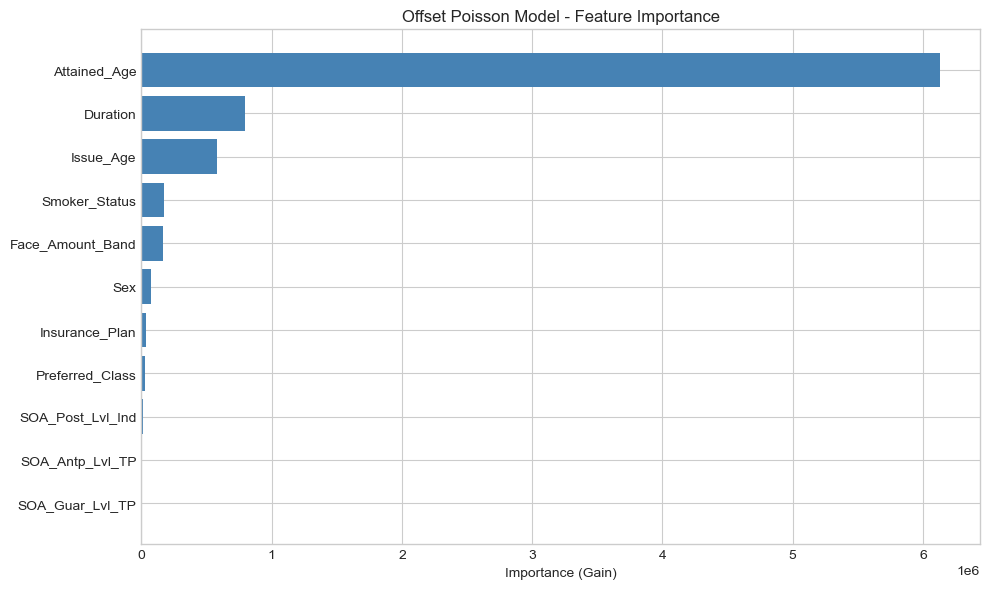

In [9]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print('Feature Importance (Gain):')
print(importance_df.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Importance (Gain)')
ax.set_title('Offset Poisson Model - Feature Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Model Evaluation

**Important**: For prediction, we need to add the offset back:
```
pred = exp(model_output + offset) = exp(model_output) * Exposure
```

In [10]:
# Predictions
# model.predict returns exp(f(X)), NOT exp(f(X) + offset)
# So we need to multiply by exposure to get expected deaths

# Raw prediction (this is the mortality RATE, not count)
raw_pred_train = model.predict(X_train)
raw_pred_test = model.predict(X_test)

# Expected deaths = rate * exposure
y_pred_train = raw_pred_train * exposure_train
y_pred_test = raw_pred_test * exposure_test

# A/E Ratio calculation
epsilon = 1e-10
def calc_ae_ratio(actual, predicted):
    return actual.sum() / (predicted.sum() + epsilon)

ae_train = calc_ae_ratio(y_train, y_pred_train)
ae_test = calc_ae_ratio(y_test, y_pred_test)

print('=== Offset Poisson Model Performance ===')
print(f'\nTrain A/E Ratio: {ae_train:.4f}')
print(f'Test A/E Ratio: {ae_test:.4f}')
print(f'\nTotal Actual Deaths (Test): {y_test.sum():,.0f}')
print(f'Total Predicted Deaths (Test): {y_pred_test.sum():,.0f}')
print(f'\nMean Predicted Rate: {raw_pred_test.mean():.6f}')

=== Offset Poisson Model Performance ===

Train A/E Ratio: 0.9997
Test A/E Ratio: 0.9925

Total Actual Deaths (Test): 89,382
Total Predicted Deaths (Test): 90,059

Mean Predicted Rate: 0.011020


## 7. Stage 2: Residual Analysis by Year

In [11]:
# Calculate residuals
residuals_test = y_test - y_pred_test

# Create DataFrame for analysis
residual_df = pd.DataFrame({
    'Year': years_test,
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Residual': residuals_test,
    'Exposure': exposure_test
})

print('Residual DataFrame created!')
residual_df.head()

Residual DataFrame created!


,Year,Actual,Predicted,Residual,Exposure
0,2015,0,0.038057,-0.038057,14.999071
1,2017,0,0.000777,-0.000777,0.687671
2,2018,0,0.000207,-0.000207,0.293151
3,2013,0,0.004402,-0.004402,3.802740
4,2016,0,0.023011,-0.023011,3.942465


In [12]:
# Aggregate residuals by year
yearly_stats = residual_df.groupby('Year').agg({
    'Actual': 'sum',
    'Predicted': 'sum',
    'Residual': 'sum',
    'Exposure': 'sum'
}).reset_index()

# Calculate A/E ratio by year
yearly_stats['AE_Ratio'] = yearly_stats['Actual'] / yearly_stats['Predicted']
yearly_stats['Actual_Rate'] = yearly_stats['Actual'] / yearly_stats['Exposure'] * 1000
yearly_stats['Predicted_Rate'] = yearly_stats['Predicted'] / yearly_stats['Exposure'] * 1000

print('=== Yearly Residual Analysis (Stage 2) ===')
print(yearly_stats.to_string(index=False))

=== Yearly Residual Analysis (Stage 2) ===
 Year  Actual    Predicted    Residual     Exposure  AE_Ratio  Actual_Rate  Predicted_Rate
 2012   10827 11120.018943 -293.018943 1.018173e+06  0.973649    10.633748       10.921537
 2013   10011 10188.842952 -177.842952 1.115590e+06  0.982545     8.973729        9.133145
 2014   11377 11336.600542   40.399458 1.161470e+06  1.003564     9.795345        9.760562
 2015   11290 11342.834516  -52.834516 1.185445e+06  0.995342     9.523853        9.568423
 2016   10664 10830.389296 -166.389296 1.149944e+06  0.984637     9.273497        9.418191
 2017   10965 10875.368459   89.631541 1.139087e+06  1.008242     9.626130        9.547443
 2018   12509 12458.131260   50.868740 1.262590e+06  1.004083     9.907413        9.867123
 2019   11739 11907.077297 -168.077297 1.243930e+06  0.985884     9.437025        9.572143


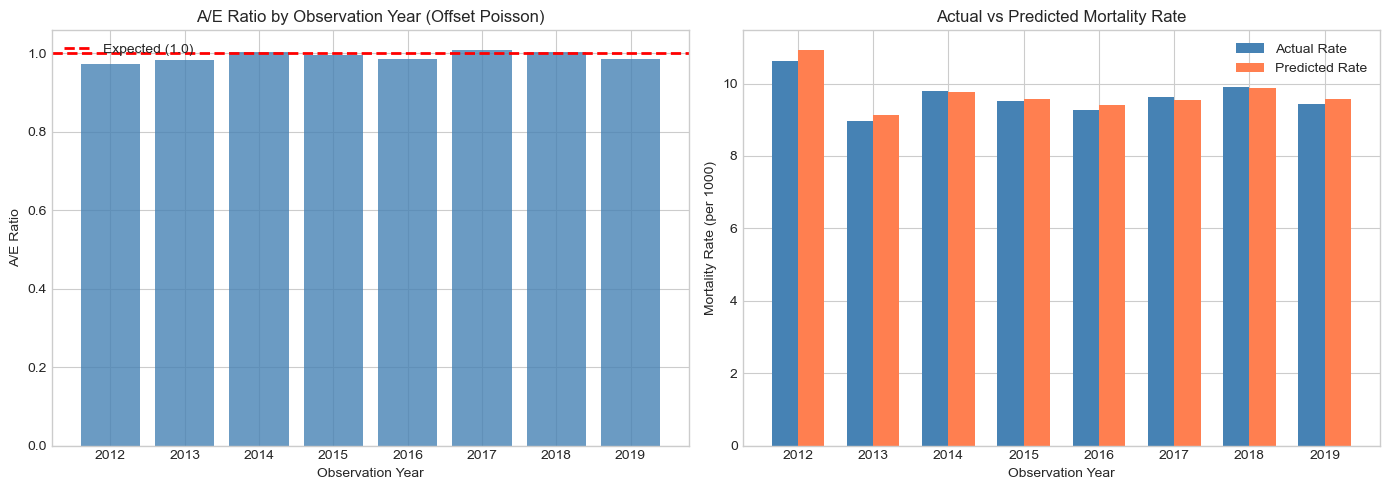

In [13]:
# Visualize yearly patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A/E Ratio by Year
axes[0].bar(yearly_stats['Year'], yearly_stats['AE_Ratio'], color='steelblue', alpha=0.8)
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Expected (1.0)')
axes[0].set_xlabel('Observation Year')
axes[0].set_ylabel('A/E Ratio')
axes[0].set_title('A/E Ratio by Observation Year (Offset Poisson)')
axes[0].legend()

# Actual vs Predicted Rate by Year
x = np.arange(len(yearly_stats))
width = 0.35
axes[1].bar(x - width/2, yearly_stats['Actual_Rate'], width, label='Actual Rate', color='steelblue')
axes[1].bar(x + width/2, yearly_stats['Predicted_Rate'], width, label='Predicted Rate', color='coral')
axes[1].set_xlabel('Observation Year')
axes[1].set_ylabel('Mortality Rate (per 1000)')
axes[1].set_title('Actual vs Predicted Mortality Rate')
axes[1].set_xticks(x)
axes[1].set_xticklabels(yearly_stats['Year'])
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Stage 2: Year Adjustment Factors

In [14]:
# Calculate year adjustment factors
yearly_stats['Year_Factor'] = yearly_stats['AE_Ratio']

print('=== Year Adjustment Factors ===' )
print('(Multiply baseline prediction by this factor for year-specific prediction)')
print()
for _, row in yearly_stats.iterrows():
    year = int(row['Year'])
    factor = row['Year_Factor']
    direction = '↑' if factor > 1 else '↓' if factor < 1 else '→'
    print(f"  {year}: {factor:.4f} {direction}")

=== Year Adjustment Factors ===
(Multiply baseline prediction by this factor for year-specific prediction)

  2012: 0.9736 ↓
  2013: 0.9825 ↓
  2014: 1.0036 ↑
  2015: 0.9953 ↓
  2016: 0.9846 ↓
  2017: 1.0082 ↑
  2018: 1.0041 ↑
  2019: 0.9859 ↓


## 9. Save Model

In [15]:
# Save model
MODEL_PATH = '../models/lgbm_mortality_offset_poisson.txt'
import os
os.makedirs('../models', exist_ok=True)

model.save_model(MODEL_PATH)
print(f'Model saved to {MODEL_PATH}')

# Save year factors
FACTORS_PATH = '../models/year_factors_offset.csv'
yearly_stats[['Year', 'Year_Factor']].to_csv(FACTORS_PATH, index=False)
print(f'Year factors saved to {FACTORS_PATH}')

Model saved to ../models/lgbm_mortality_offset_poisson.txt
Year factors saved to ../models/year_factors_offset.csv


## Summary

### Offset Poisson Model

| Component | Formula | Implementation |
|-----------|---------|----------------|
| GLM | log(E[D]) = log(E) + f(X) | init_score=log(Exposure) |
| Prediction | E[D] = exp(f(X)) * Exposure | raw_pred * exposure |

### Key Differences from Previous Version

| Aspect | Before | After |
|--------|--------|-------|
| Offset | sample_weight | init_score |
| Prediction | Direct use | raw * exposure |
| Interpretation | Death count | Mortality rate |

### Expected A/E Ratio
With correct offset modeling, A/E should be closer to 1.0